In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool

In [2]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [3]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
  m_data={}
  m_data['run_id'] =run_id
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [175]:
#Plotting Confusion Matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    return fig

In [4]:
data_path='breast_cancer.csv'

In [5]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)


In [6]:
all_variables=None

In [7]:
run_id=alphabet(9)
# run_id to std out
print (run_id)

31NZIQ11j


In [8]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)

In [9]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:11242..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from C:\Users\ptari\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ptari\AppData\Local\Temp\tmpmcz72dxm
  JVM stdout: C:\Users\ptari\AppData\Local\Temp\tmpmcz72dxm\h2o_ptari_started_from_python.out
  JVM stderr: C:\Users\ptari\AppData\Local\Temp\tmpmcz72dxm\h2o_ptari_started_from_python.err
  Server is running at http://127.0.0.1:11242
Connecting to H2O server at http://127.0.0.1:11242... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_ptari_w7desc
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [10]:
# meta data
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': '31NZIQ11j', 'start_time': 1541106858.8285453, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1541106858.8285453, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [11]:
print(data_path)

C:\Users\ptari\Desktop\INFO 7245\Assignment 2\assignment 2.2\breast_cancer.csv


In [12]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
df.head()

id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
842302,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,M
842517,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,M
8.43009e+07,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,M
8.43483e+07,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,M
8.43584e+07,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678,M
843786,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244,M
844359,18.25,19.98,119.6,1040,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,M
8.44582e+07,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,M
844981,13,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072,M
8.4501e+07,12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0.2976,1.599,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.01008,15.09,40.68,97.65,711.4,0.1853,1.058,1.105,0.221,0.4366,0.2075,M


In [14]:
df.describe()

Rows:569
Cols:32




,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
type,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum
mins,8670.0,6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,0.0,0.106,0.04996,0.1115,0.3602,0.757,6.802,0.001713,0.002252,0.0,0.0,0.007882,0.0008948,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504,
mean,30371831.43233744,14.127291739894554,19.289648506151142,91.96903339191564,654.8891036906855,0.09636028119507907,0.10434098418277679,0.0887993158172232,0.04891914586994728,0.18116186291739897,0.06279760984182778,0.40517205623901575,1.2168534270650264,2.8660592267135327,40.337079086116,0.007040978910369069,0.025478138840070295,0.031893716344463974,0.011796137082601056,0.02054229876977153,0.0037949038664323374,16.269189806678384,25.677223198594024,107.26121265377856,880.5831282952548,0.13236859402460457,0.2542650439367311,0.27218848330404216,0.11460622319859404,0.2900755711775044,0.0839458172231986,
maxs,911320502.0,28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,0.2012,0.304,0.09744,2.873,4.885,21.98,542.2,0.03113,0.1354,0.396,0.05279,0.07895,0.02984,36.04,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075,
sigma,125020585.61222365,3.524048826212078,4.30103576816695,24.2989810387549,351.914129181653,0.014064128137673616,0.052812757932512194,0.07971980870789348,0.038802844859153605,0.027414281336035712,0.00706036279508446,0.2773127329861039,0.5516483926172022,2.0218545540421076,45.49100551613181,0.003002517943839066,0.017908179325677388,0.030186060322988408,0.006170285174046869,0.008266371528798397,0.002646070967089195,4.833241580469323,6.146257623038319,33.602542269036356,569.356992669949,0.022832429404835472,0.157336488913742,0.2086242806081323,0.06573234119594207,0.06186746753751869,0.018061267348893986,
zeros,0,0,0,0,0,0,0,13,13,0,0,0,0,0,0,0,0,13,13,0,0,0,0,0,0,0,0,13,13,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,842302.0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,M
1,842517.0,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,M
2,84300903.0,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,M


In [15]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[-1]   
y = target

In [16]:
print(y)

diagnosis


In [19]:
print(all_variables)

None


In [18]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [20]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [21]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [22]:
print(classification)

False


In [23]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [24]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok, val

In [25]:
ok,val=check_y(y,df)

In [26]:
print(val)

enum


In [27]:
print(ok)

True


In [28]:
if val=='enum':
    print(df[y].levels())

[['B', 'M']]


In [29]:
allV=get_variables_types(df)
allV

{'area_mean': 'real',
 'area_se': 'real',
 'area_worst': 'real',
 'compactness_mean': 'real',
 'compactness_se': 'real',
 'compactness_worst': 'real',
 'concave points_mean': 'real',
 'concave points_se': 'real',
 'concave points_worst': 'real',
 'concavity_mean': 'real',
 'concavity_se': 'real',
 'concavity_worst': 'real',
 'diagnosis': 'enum',
 'fractal_dimension_mean': 'real',
 'fractal_dimension_se': 'real',
 'fractal_dimension_worst': 'real',
 'id': 'int',
 'perimeter_mean': 'real',
 'perimeter_se': 'real',
 'perimeter_worst': 'real',
 'radius_mean': 'real',
 'radius_se': 'real',
 'radius_worst': 'real',
 'smoothness_mean': 'real',
 'smoothness_se': 'real',
 'smoothness_worst': 'real',
 'symmetry_mean': 'real',
 'symmetry_se': 'real',
 'symmetry_worst': 'real',
 'texture_mean': 'real',
 'texture_se': 'real',
 'texture_worst': 'real'}

In [30]:
meta_data['variables']=allV

In [31]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.9])

In [32]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [33]:
model_start_time = time.time()

In [34]:
aml.train(x=X,y=y,training_frame=train)


AutoML progress: |████████████████████████████████████████████████████████| 100%


In [35]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [36]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_grid_0_AutoML_20181101_171828_model_19,0.994951,0.084078,0.028044,0.149942,0.022483
1,GBM_grid_0_AutoML_20181101_171828_model_30,0.993720,0.087116,0.030744,0.148942,0.022184
2,GBM_grid_0_AutoML_20181101_171828_model_6,0.993494,0.083322,0.024327,0.144018,0.020741
3,GBM_grid_0_AutoML_20181101_171828_model_1,0.993369,0.095012,0.026186,0.152650,0.023302
4,GBM_grid_0_AutoML_20181101_171828_model_16,0.993143,0.126343,0.028383,0.169952,0.028884
5,GBM_grid_0_AutoML_20181101_171828_model_11,0.992892,0.088425,0.022807,0.148049,0.021919
6,GBM_grid_0_AutoML_20181101_171828_model_15,0.992716,0.122421,0.029903,0.166348,0.027672
7,GBM_grid_0_AutoML_20181101_171828_model_20,0.992716,0.090809,0.020948,0.148629,0.022091
8,StackedEnsemble_BestOfFamily_0_AutoML_20181101...,0.992088,0.078124,0.021288,0.140211,0.019659
9,GLM_grid_0_AutoML_20181101_171828_model_0,0.992038,0.084287,0.025507,0.141896,0.020135


In [49]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

## GBM

In [52]:
gbm = mod_best._id
gbm

'GBM_grid_0_AutoML_20181101_171828_model_19'

Confusion Matrix

In [56]:
mod_best.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


In [57]:
mod_best.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.998127415902459: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,147.0,1.0,0.9932,(147.0/148.0)
Total,416.0,1.0,0.3525,(147.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.998127415902459: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,147.0,1.0,0.9932,(147.0/148.0)
Total,416.0,1.0,0.3525,(147.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


[, , , , , , , , , ]

In [58]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics>

In [59]:
type(mod_best)

h2o.estimators.gbm.H2OGradientBoostingEstimator

In [60]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_0_AutoML_20181101_171828_model_19


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 8.725328652034925e-05
RMSE: 0.009340946767879006
LogLoss: 0.004594706366768465
Mean Per-Class Error: 0.0
AUC: 1.0
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8966875174084215: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,269.0,148.0,0.0,(0.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8966875,1.0,144.0
max f2,0.8966875,1.0,144.0
max f0point5,0.8966875,1.0,144.0
max accuracy,0.8966875,1.0,144.0
max precision,0.9981274,1.0,0.0
max recall,0.8966875,1.0,144.0
max specificity,0.9981274,1.0,0.0
max absolute_mcc,0.8966875,1.0,144.0
max min_per_class_accuracy,0.8966875,1.0,144.0
max mean_per_class_accuracy,0.8966875,1.0,144.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 35.47 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0119904,0.9981061,2.8175676,2.8175676,1.0,0.9981154,1.0,0.9981154,0.0337838,0.0337838,181.7567568,181.7567568
,2,0.0215827,0.9980654,2.8175676,2.8175676,1.0,0.9980811,1.0,0.9981002,0.0270270,0.0608108,181.7567568,181.7567568
,3,0.0311751,0.9980311,2.8175676,2.8175676,1.0,0.9980464,1.0,0.9980836,0.0270270,0.0878378,181.7567568,181.7567568
,4,0.0407674,0.9980020,2.8175676,2.8175676,1.0,0.9980098,1.0,0.9980663,0.0270270,0.1148649,181.7567568,181.7567568
,5,0.0503597,0.9979791,2.8175676,2.8175676,1.0,0.9979909,1.0,0.9980519,0.0270270,0.1418919,181.7567568,181.7567568
,6,0.1007194,0.9978021,2.8175676,2.8175676,1.0,0.9978845,1.0,0.9979682,0.1418919,0.2837838,181.7567568,181.7567568
,7,0.1510791,0.9974487,2.8175676,2.8175676,1.0,0.9976834,1.0,0.9978733,0.1418919,0.4256757,181.7567568,181.7567568
,8,0.2014388,0.9967618,2.8175676,2.8175676,1.0,0.9971709,1.0,0.9976977,0.1418919,0.5675676,181.7567568,181.7567568
,9,0.2997602,0.9895620,2.8175676,2.8175676,1.0,0.9943900,1.0,0.9966128,0.2770270,0.8445946,181.7567568,181.7567568
,10,0.4004796,0.0114924,1.5429537,2.4970060,0.5476190,0.5428435,0.8862275,0.8824911,0.1554054,1.0,54.2953668,149.7005988




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.04430163880167658
RMSE: 0.2104795448533576
LogLoss: 0.12347704631577848
Mean Per-Class Error: 0.018867924528301883
AUC: 0.9953980671882191
Gini: 0.9907961343764382
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11099959562203308: 


,B,M,Error,Rate
B,51.0,2.0,0.0377,(2.0/53.0)
M,0.0,41.0,0.0,(0.0/41.0)
Total,51.0,43.0,0.0213,(2.0/94.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1109996,0.9761905,42.0
max f2,0.1109996,0.9903382,42.0
max f0point5,0.2772538,0.9701493,39.0
max accuracy,0.1109996,0.9787234,42.0
max precision,0.9981232,1.0,0.0
max recall,0.1109996,1.0,42.0
max specificity,0.9981232,1.0,0.0
max absolute_mcc,0.1109996,0.9578662,42.0
max min_per_class_accuracy,0.2588897,0.9622642,41.0
max mean_per_class_accuracy,0.1109996,0.9811321,42.0


Gains/Lift Table: Avg response rate: 43.62 %, avg score: 38.76 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0106383,0.9981121,2.2926829,2.2926829,1.0,0.9981232,1.0,0.9981232,0.0243902,0.0243902,129.2682927,129.2682927
,2,0.0212766,0.9981031,2.2926829,2.2926829,1.0,0.9981112,1.0,0.9981172,0.0243902,0.0487805,129.2682927,129.2682927
,3,0.0319149,0.9980624,2.2926829,2.2926829,1.0,0.9981018,1.0,0.9981121,0.0243902,0.0731707,129.2682927,129.2682927
,4,0.0425532,0.9980132,2.2926829,2.2926829,1.0,0.9980519,1.0,0.9980970,0.0243902,0.0975610,129.2682927,129.2682927
,5,0.0531915,0.9979764,2.2926829,2.2926829,1.0,0.9979981,1.0,0.9980773,0.0243902,0.1219512,129.2682927,129.2682927
,6,0.1063830,0.9976274,2.2926829,2.2926829,1.0,0.9978195,1.0,0.9979484,0.1219512,0.2439024,129.2682927,129.2682927
,7,0.1489362,0.9970195,2.2926829,2.2926829,1.0,0.9975151,1.0,0.9978246,0.0975610,0.3414634,129.2682927,129.2682927
,8,0.2021277,0.9952696,2.2926829,2.2926829,1.0,0.9963954,1.0,0.9974485,0.1219512,0.4634146,129.2682927,129.2682927
,9,0.2978723,0.9778763,2.2926829,2.2926829,1.0,0.9901523,1.0,0.9951033,0.2195122,0.6829268,129.2682927,129.2682927
,10,0.4042553,0.3347559,2.0634146,2.2323492,0.9,0.6943734,0.9736842,0.9159638,0.2195122,0.9024390,106.3414634,123.2349166




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.022482582393773567
RMSE: 0.14994193007219017
LogLoss: 0.08407808466932246
Mean Per-Class Error: 0.028044308248769134
AUC: 0.9949512709735757
Gini: 0.9899025419471514
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3836965580654469: 


,B,M,Error,Rate
B,263.0,6.0,0.0223,(6.0/269.0)
M,5.0,143.0,0.0338,(5.0/148.0)
Total,268.0,149.0,0.0264,(11.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3836966,0.9629630,144.0
max f2,0.1587677,0.9679573,152.0
max f0point5,0.8299984,0.9754335,131.0
max accuracy,0.3836966,0.9736211,144.0
max precision,0.9998891,1.0,0.0
max recall,0.0086395,1.0,208.0
max specificity,0.9998891,1.0,0.0
max absolute_mcc,0.3836966,0.9424920,144.0
max min_per_class_accuracy,0.3836966,0.9662162,144.0
max mean_per_class_accuracy,0.3836966,0.9719557,144.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 34.85 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0119904,0.9998774,2.8175676,2.8175676,1.0,0.9998837,1.0,0.9998837,0.0337838,0.0337838,181.7567568,181.7567568
,2,0.0215827,0.9998458,2.8175676,2.8175676,1.0,0.9998662,1.0,0.9998759,0.0270270,0.0608108,181.7567568,181.7567568
,3,0.0311751,0.9997598,2.8175676,2.8175676,1.0,0.9998043,1.0,0.9998539,0.0270270,0.0878378,181.7567568,181.7567568
,4,0.0407674,0.9993740,2.8175676,2.8175676,1.0,0.9994904,1.0,0.9997684,0.0270270,0.1148649,181.7567568,181.7567568
,5,0.0503597,0.9993031,2.8175676,2.8175676,1.0,0.9993546,1.0,0.9996895,0.0270270,0.1418919,181.7567568,181.7567568
,6,0.1007194,0.9963664,2.8175676,2.8175676,1.0,0.9984672,1.0,0.9990784,0.1418919,0.2837838,181.7567568,181.7567568
,7,0.1510791,0.9927043,2.8175676,2.8175676,1.0,0.9941530,1.0,0.9974366,0.1418919,0.4256757,181.7567568,181.7567568
,8,0.2014388,0.9884651,2.8175676,2.8175676,1.0,0.9905942,1.0,0.9957260,0.1418919,0.5675676,181.7567568,181.7567568
,9,0.2997602,0.9439135,2.7488464,2.7950270,0.9756098,0.9802184,0.992,0.9906395,0.2702703,0.8378378,174.8846407,179.5027027
,10,0.4004796,0.0504009,1.4087838,2.4463910,0.5,0.4769098,0.8682635,0.8614380,0.1418919,0.9797297,40.8783784,144.6391002



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9831899,0.0087041,0.9880952,0.9880952,0.9759036,0.9638554,1.0
auc,0.9938086,0.0032377,0.9982353,0.9923611,0.9880503,0.9903961,1.0
err,0.0168101,0.0087041,0.0119048,0.0119048,0.0240964,0.0361446,0.0
err_count,1.4,0.7211103,1.0,1.0,2.0,3.0,0.0
f0point5,0.9766667,0.0129115,0.9770115,0.9913793,0.9666666,0.9482759,1.0
f1,0.9774838,0.0106269,0.9855072,0.9787234,0.9666666,0.9565217,1.0
f2,0.9784235,0.0108563,0.9941521,0.9663866,0.9666666,0.9649123,1.0
lift_top_group,2.874148,0.2923685,2.4705882,3.5,2.7666667,2.4411764,3.1923077
logloss,0.0840978,0.0261365,0.0729495,0.0870149,0.1083685,0.1307620,0.0213942
max_per_class_error,0.0271633,0.0110634,0.02,0.0416667,0.0333333,0.0408163,0.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-11-01 17:20:44,1 min 46.567 sec,0.0,0.4784879,0.6504369,0.5,1.0,0.6450839,0.5025216,0.6989862,0.5,1.0,0.5638298
,2018-11-01 17:20:44,1 min 46.589 sec,5.0,0.3809366,0.4699504,0.9998995,2.8175676,0.0047962,0.4187457,0.5340051,0.9880350,2.2926829,0.0638298
,2018-11-01 17:20:45,1 min 46.619 sec,10.0,0.3060686,0.3539237,0.9998493,2.8175676,0.0047962,0.3566493,0.4276028,0.9894156,2.2926829,0.0531915
,2018-11-01 17:20:45,1 min 46.644 sec,15.0,0.2468476,0.2715863,0.9999498,2.8175676,0.0023981,0.3114389,0.3539051,0.9903359,2.2926829,0.0531915
,2018-11-01 17:20:45,1 min 46.666 sec,20.0,0.2030022,0.2142073,0.9999498,2.8175676,0.0023981,0.2827238,0.3053763,0.9894156,2.2926829,0.0531915
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-11-01 17:20:45,1 min 47.101 sec,100.0,0.0147156,0.0082274,1.0,2.8175676,0.0,0.2128851,0.1299639,0.9949379,2.2926829,0.0319149
,2018-11-01 17:20:45,1 min 47.125 sec,105.0,0.0131909,0.0068861,1.0,2.8175676,0.0,0.2093006,0.1243006,0.9958583,2.2926829,0.0212766
,2018-11-01 17:20:45,1 min 47.156 sec,110.0,0.0111373,0.0057028,1.0,2.8175676,0.0,0.2124765,0.1269457,0.9953981,2.2926829,0.0212766
,2018-11-01 17:20:45,1 min 47.187 sec,115.0,0.0096529,0.0047644,1.0,2.8175676,0.0,0.2106627,0.1240695,0.9958583,2.2926829,0.0212766



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
concave points_mean,153.2989044,1.0,0.1621791
perimeter_worst,139.4512787,0.9096691,0.1475293
concave points_worst,104.0784454,0.6789249,0.1101074
area_mean,74.8215332,0.4880761,0.0791557
radius_worst,61.0014915,0.3979252,0.0645351
---,---,---,---
symmetry_se,1.8534694,0.0120906,0.0019608
concave points_se,1.7387568,0.0113423,0.0018395
radius_se,1.6000111,0.0104372,0.0016927
symmetry_mean,1.2100910,0.0078937,0.0012802



See the whole table with table.as_data_frame()
<bound method ModelBase.coef_norm of >


Gain Lift Table

In [98]:
gbm_gain_lift = mod_best.gains_lift().as_data_frame()

In [99]:
gbm_gain_lift

,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011990,0.998106,2.817568,2.817568,1.000000,0.998115,1.000000,0.998115,0.033784,0.033784,181.756757,181.756757
1,,2,0.021583,0.998065,2.817568,2.817568,1.000000,0.998081,1.000000,0.998100,0.027027,0.060811,181.756757,181.756757
2,,3,0.031175,0.998031,2.817568,2.817568,1.000000,0.998046,1.000000,0.998084,0.027027,0.087838,181.756757,181.756757
3,,4,0.040767,0.998002,2.817568,2.817568,1.000000,0.998010,1.000000,0.998066,0.027027,0.114865,181.756757,181.756757
4,,5,0.050360,0.997979,2.817568,2.817568,1.000000,0.997991,1.000000,0.998052,0.027027,0.141892,181.756757,181.756757
5,,6,0.100719,0.997802,2.817568,2.817568,1.000000,0.997885,1.000000,0.997968,0.141892,0.283784,181.756757,181.756757
6,,7,0.151079,0.997449,2.817568,2.817568,1.000000,0.997683,1.000000,0.997873,0.141892,0.425676,181.756757,181.756757
7,,8,0.201439,0.996762,2.817568,2.817568,1.000000,0.997171,1.000000,0.997698,0.141892,0.567568,181.756757,181.756757
8,,9,0.299760,0.989562,2.817568,2.817568,1.000000,0.994390,1.000000,0.996613,0.277027,0.844595,181.756757,181.756757
9,,10,0.400480,0.011492,1.542954,2.497006,0.547619,0.542843,0.886228,0.882491,0.155405,1.000000,54.295367,149.700599


In [100]:
gbm_predictions_df=predictions_test(mod_best,test,run_id)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [101]:
gbm_predictions_df.head()

predict,B,M
M,0.0254218,0.974578
M,0.00364481,0.996355
M,0.0131194,0.986881
M,0.00207514,0.997925
M,0.00273859,0.997261
B,0.984861,0.0151394
B,0.974138,0.0258624
M,0.756796,0.243204
B,0.955198,0.0448021
M,0.00592085,0.994079


In [131]:
gbm_predictions_df.describe()

Rows:58
Cols:3




,predict,B,M
type,enum,real,real
mins,,0.002075135266529693,0.0010468100665216112
mean,,0.6217691021177613,0.3782308978822388
maxs,,0.9989531899334784,0.9979248647334703
sigma,,0.4633146893404552,0.4633146893404552
zeros,,0,0
missing,0,0,0
0,M,0.025421766189176354,0.9745782338108236
1,M,0.003644810067294002,0.996355189932706
2,M,0.013119387444179398,0.9868806125558206


In [165]:
y_pred= gbm_predictions_df['predict'].as_data_frame()
y_act= test['diagnosis'].as_data_frame()

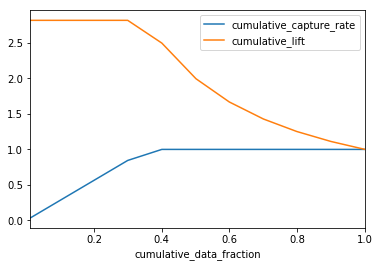

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline 
# plot training logloss and auc
#gbm_predictions_df.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])
gbm_gain_lift.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_act,y_pred)

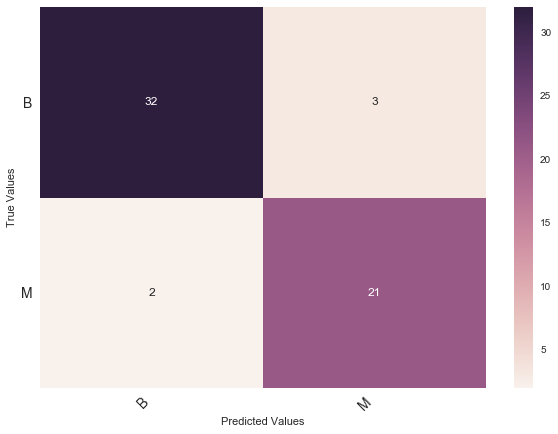

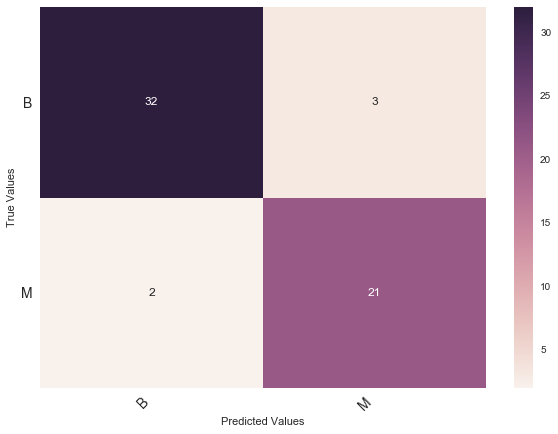

In [173]:
class_name = ['B','M']
print_confusion_matrix(cm,class_name)

Variable Importance

In [189]:
gbm_varimp=pd.DataFrame(mod_best.varimp())
gbm_varimp.head()

,0,1,2,3
0,concave points_mean,153.298904,1.000000,0.162179
1,perimeter_worst,139.451279,0.909669,0.147529
2,concave points_worst,104.078445,0.678925,0.110107
3,area_mean,74.821533,0.488076,0.079156
4,radius_worst,61.001492,0.397925,0.064535


In [191]:
#variable	relative_importance	scaled_importance	percentage
gbm_varimp.rename(columns={0:"variable",1:"relative_importance",2:"scaled_importance",3:"percentage"}).head()

,variable,relative_importance,scaled_importance,percentage
0,concave points_mean,153.298904,1.000000,0.162179
1,perimeter_worst,139.451279,0.909669,0.147529
2,concave points_worst,104.078445,0.678925,0.110107
3,area_mean,74.821533,0.488076,0.079156
4,radius_worst,61.001492,0.397925,0.064535


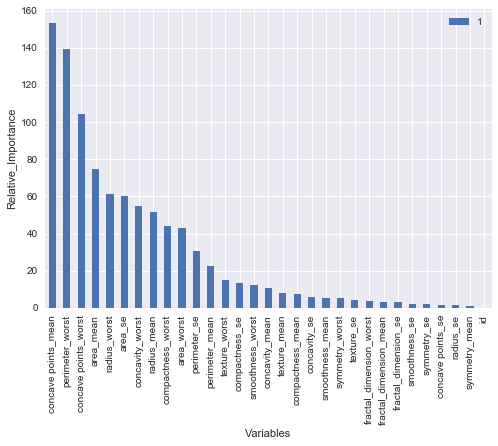

In [192]:
gbm_varimp.plot.bar(x=0,y=[1])
plt.xlabel('Variables')
plt.ylabel('Relative_Importance')

## Stacked Ensemble

In [194]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])
se = mod_best._id
se

'StackedEnsemble_BestOfFamily_0_AutoML_20181101_171828'

Confusion Matrix

In [195]:
mod_best.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


In [196]:
mod_best.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.3427932686432317: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,2.0,146.0,0.0135,(2.0/148.0)
Total,271.0,146.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.3427932686432317: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,2.0,146.0,0.0135,(2.0/148.0)
Total,271.0,146.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.9959664395085774: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,147.0,1.0,0.9932,(147.0/148.0)
Total,416.0,1.0,0.3525,(147.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.9959664395085774: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,147.0,1.0,0.9932,(147.0/148.0)
Total,416.0,1.0,0.3525,(147.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max min_per_class_accuracy @ threshold = 0.26666735197557184: 


,B,M,Error,Rate
B,268.0,1.0,0.0037,(1.0/269.0)
M,1.0,147.0,0.0068,(1.0/148.0)
Total,269.0,148.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


[, , , , , , , , , ]

In [197]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics>

In [198]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [199]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181101_171828
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0045468790162855235
RMSE: 0.06743054957721703
LogLoss: 0.02243213656828987
Null degrees of freedom: 416
Residual degrees of freedom: 412
Null deviance: 542.4643537202328
Residual deviance: 18.708401897953742
AIC: 28.708401897953742
AUC: 0.9999246458354265
Gini: 0.999849291670853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1697925826679713: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1697926,0.9932886,137.0
max f2,0.1697926,0.9973046,137.0
max f0point5,0.3427933,0.9972678,133.0
max accuracy,0.3427933,0.9952038,133.0
max precision,0.9959664,1.0,0.0
max recall,0.1697926,1.0,137.0
max specificity,0.9959664,1.0,0.0
max absolute_mcc,0.1697926,0.9896115,137.0
max min_per_class_accuracy,0.2666674,0.9932432,135.0
max mean_per_class_accuracy,0.1697926,0.9962825,137.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 35.59 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0119904,0.9959662,2.8175676,2.8175676,1.0,0.9959663,1.0,0.9959663,0.0337838,0.0337838,181.7567568,181.7567568
,2,0.0215827,0.9959659,2.8175676,2.8175676,1.0,0.9959660,1.0,0.9959662,0.0270270,0.0608108,181.7567568,181.7567568
,3,0.0311751,0.9959655,2.8175676,2.8175676,1.0,0.9959657,1.0,0.9959661,0.0270270,0.0878378,181.7567568,181.7567568
,4,0.0407674,0.9959651,2.8175676,2.8175676,1.0,0.9959654,1.0,0.9959659,0.0270270,0.1148649,181.7567568,181.7567568
,5,0.0503597,0.9959648,2.8175676,2.8175676,1.0,0.9959650,1.0,0.9959657,0.0270270,0.1418919,181.7567568,181.7567568
,6,0.1007194,0.9959625,2.8175676,2.8175676,1.0,0.9959636,1.0,0.9959647,0.1418919,0.2837838,181.7567568,181.7567568
,7,0.1510791,0.9959535,2.8175676,2.8175676,1.0,0.9959594,1.0,0.9959629,0.1418919,0.4256757,181.7567568,181.7567568
,8,0.2014388,0.9959028,2.8175676,2.8175676,1.0,0.9959362,1.0,0.9959562,0.1418919,0.5675676,181.7567568,181.7567568
,9,0.2997602,0.9916477,2.8175676,2.8175676,1.0,0.9951180,1.0,0.9956813,0.2770270,0.8445946,181.7567568,181.7567568
,10,0.4004796,0.0262233,1.5429537,2.4970060,0.5476190,0.5080315,0.8862275,0.8730388,0.1554054,1.0,54.2953668,149.7005988




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.009288004065626182
RMSE: 0.09637429151815427
LogLoss: 0.040418142997807535
Null degrees of freedom: 93
Residual degrees of freedom: 89
Null deviance: 131.4093970117223
Residual deviance: 7.598610883587815
AIC: 17.598610883587817
AUC: 1.0
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4350264114407421: 


,B,M,Error,Rate
B,53.0,0.0,0.0,(0.0/53.0)
M,0.0,41.0,0.0,(0.0/41.0)
Total,53.0,41.0,0.0,(0.0/94.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4350264,1.0,39.0
max f2,0.4350264,1.0,39.0
max f0point5,0.4350264,1.0,39.0
max accuracy,0.4350264,1.0,39.0
max precision,0.9959664,1.0,0.0
max recall,0.4350264,1.0,39.0
max specificity,0.9959664,1.0,0.0
max absolute_mcc,0.4350264,1.0,39.0
max min_per_class_accuracy,0.4350264,1.0,39.0
max mean_per_class_accuracy,0.4350264,1.0,39.0


Gains/Lift Table: Avg response rate: 43.62 %, avg score: 42.18 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0106383,0.9959663,2.2926829,2.2926829,1.0,0.9959664,1.0,0.9959664,0.0243902,0.0243902,129.2682927,129.2682927
,2,0.0212766,0.9959662,2.2926829,2.2926829,1.0,0.9959663,1.0,0.9959663,0.0243902,0.0487805,129.2682927,129.2682927
,3,0.0319149,0.9959658,2.2926829,2.2926829,1.0,0.9959662,1.0,0.9959663,0.0243902,0.0731707,129.2682927,129.2682927
,4,0.0425532,0.9959653,2.2926829,2.2926829,1.0,0.9959657,1.0,0.9959661,0.0243902,0.0975610,129.2682927,129.2682927
,5,0.0531915,0.9959645,2.2926829,2.2926829,1.0,0.9959652,1.0,0.9959659,0.0243902,0.1219512,129.2682927,129.2682927
,6,0.1063830,0.9959602,2.2926829,2.2926829,1.0,0.9959627,1.0,0.9959643,0.1219512,0.2439024,129.2682927,129.2682927
,7,0.1489362,0.9959432,2.2926829,2.2926829,1.0,0.9959554,1.0,0.9959618,0.0975610,0.3414634,129.2682927,129.2682927
,8,0.2021277,0.9958242,2.2926829,2.2926829,1.0,0.9959052,1.0,0.9959469,0.1219512,0.4634146,129.2682927,129.2682927
,9,0.2978723,0.9925317,2.2926829,2.2926829,1.0,0.9951311,1.0,0.9956846,0.2195122,0.6829268,129.2682927,129.2682927
,10,0.4042553,0.7904326,2.2926829,2.2926829,1.0,0.9336110,1.0,0.9793495,0.2439024,0.9268293,129.2682927,129.2682927




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.01965918392410031
RMSE: 0.14021121183450455
LogLoss: 0.07812424882474653
Null degrees of freedom: 416
Residual degrees of freedom: 412
Null deviance: 543.9771262603819
Residual deviance: 65.15562351983861
AIC: 75.15562351983861
AUC: 0.992087812719783
Gini: 0.9841756254395659
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19224675478735598: 


,B,M,Error,Rate
B,263.0,6.0,0.0223,(6.0/269.0)
M,3.0,145.0,0.0203,(3.0/148.0)
Total,266.0,151.0,0.0216,(9.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1922468,0.9698997,138.0
max f2,0.1922468,0.9757739,138.0
max f0point5,0.9537067,0.9811047,122.0
max accuracy,0.3288586,0.9784173,134.0
max precision,0.9966978,1.0,0.0
max recall,0.0087557,1.0,332.0
max specificity,0.9966978,1.0,0.0
max absolute_mcc,0.1922468,0.9531965,138.0
max min_per_class_accuracy,0.1922468,0.9776952,138.0
max mean_per_class_accuracy,0.1922468,0.9787124,138.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 35.36 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0119904,0.9966970,2.8175676,2.8175676,1.0,0.9966977,1.0,0.9966977,0.0337838,0.0337838,181.7567568,181.7567568
,2,0.0215827,0.9966928,2.8175676,2.8175676,1.0,0.9966940,1.0,0.9966960,0.0270270,0.0608108,181.7567568,181.7567568
,3,0.0311751,0.9966706,2.8175676,2.8175676,1.0,0.9966833,1.0,0.9966921,0.0270270,0.0878378,181.7567568,181.7567568
,4,0.0407674,0.9966486,2.8175676,2.8175676,1.0,0.9966589,1.0,0.9966843,0.0270270,0.1148649,181.7567568,181.7567568
,5,0.0503597,0.9966400,2.8175676,2.8175676,1.0,0.9966459,1.0,0.9966770,0.0270270,0.1418919,181.7567568,181.7567568
,6,0.1007194,0.9959022,2.8175676,2.8175676,1.0,0.9962873,1.0,0.9964821,0.1418919,0.2837838,181.7567568,181.7567568
,7,0.1510791,0.9945282,2.8175676,2.8175676,1.0,0.9954347,1.0,0.9961330,0.1418919,0.4256757,181.7567568,181.7567568
,8,0.2014388,0.9937242,2.8175676,2.8175676,1.0,0.9943743,1.0,0.9956933,0.1418919,0.5675676,181.7567568,181.7567568
,9,0.2997602,0.9845325,2.8175676,2.8175676,1.0,0.9919507,1.0,0.9944657,0.2770270,0.8445946,181.7567568,181.7567568
,10,0.4004796,0.0390917,1.3416988,2.4463910,0.4761905,0.4853264,0.8682635,0.8664187,0.1351351,0.9797297,34.1698842,144.6391002



<bound method ModelBase.coef_norm of >


Gain Lift Table

In [200]:
se_gain_lift = mod_best.gains_lift().as_data_frame()
se_gain_lift

,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011990,0.995966,2.817568,2.817568,1.000000,0.995966,1.000000,0.995966,0.033784,0.033784,181.756757,181.756757
1,,2,0.021583,0.995966,2.817568,2.817568,1.000000,0.995966,1.000000,0.995966,0.027027,0.060811,181.756757,181.756757
2,,3,0.031175,0.995965,2.817568,2.817568,1.000000,0.995966,1.000000,0.995966,0.027027,0.087838,181.756757,181.756757
3,,4,0.040767,0.995965,2.817568,2.817568,1.000000,0.995965,1.000000,0.995966,0.027027,0.114865,181.756757,181.756757
4,,5,0.050360,0.995965,2.817568,2.817568,1.000000,0.995965,1.000000,0.995966,0.027027,0.141892,181.756757,181.756757
5,,6,0.100719,0.995962,2.817568,2.817568,1.000000,0.995964,1.000000,0.995965,0.141892,0.283784,181.756757,181.756757
6,,7,0.151079,0.995953,2.817568,2.817568,1.000000,0.995959,1.000000,0.995963,0.141892,0.425676,181.756757,181.756757
7,,8,0.201439,0.995903,2.817568,2.817568,1.000000,0.995936,1.000000,0.995956,0.141892,0.567568,181.756757,181.756757
8,,9,0.299760,0.991648,2.817568,2.817568,1.000000,0.995118,1.000000,0.995681,0.277027,0.844595,181.756757,181.756757
9,,10,0.400480,0.026223,1.542954,2.497006,0.547619,0.508031,0.886228,0.873039,0.155405,1.000000,54.295367,149.700599


In [201]:
se_prediction_df=predictions_test(mod_best,test,run_id)
se_prediction_df.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,B,M
M,0.00507991,0.99492
M,0.0042037,0.995796
M,0.00491119,0.995089
M,0.00403938,0.995961
M,0.00406082,0.995939
B,0.975727,0.024273
B,0.590578,0.409422
M,0.123469,0.876531
B,0.967328,0.0326719
M,0.00418946,0.995811


In [203]:
se_prediction_df.describe()

Rows:58
Cols:3




,predict,B,M
type,enum,real,real
mins,,0.004035958691330999,0.009007318316260095
mean,,0.5880640097366142,0.41193599026338573
maxs,,0.9909926816837399,0.995964041308669
sigma,,0.4632005683318037,0.4632005683318037
zeros,,0,0
missing,0,0,0
0,M,0.005079913903096589,0.9949200860969034
1,M,0.004203699504640723,0.9957963004953593
2,M,0.004911187283380136,0.9950888127166199


In [204]:
y_pred= gbm_predictions_df['predict'].as_data_frame()
y_act= test['diagnosis'].as_data_frame()

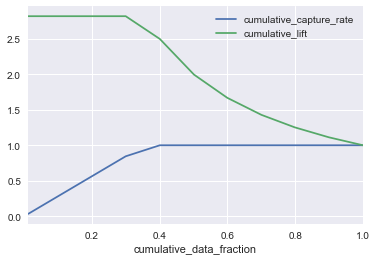

In [205]:
%matplotlib inline 
# plot training logloss and auc
#gbm_predictions_df.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])
se_gain_lift.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])

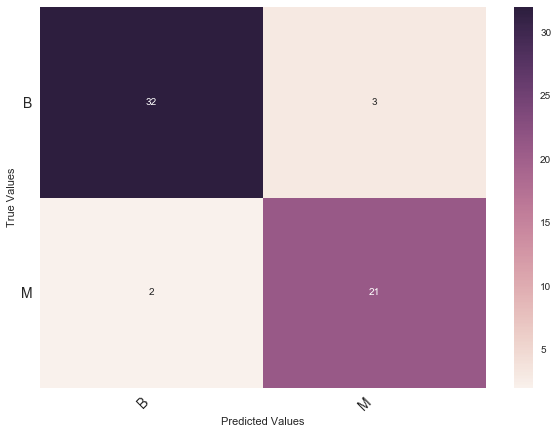

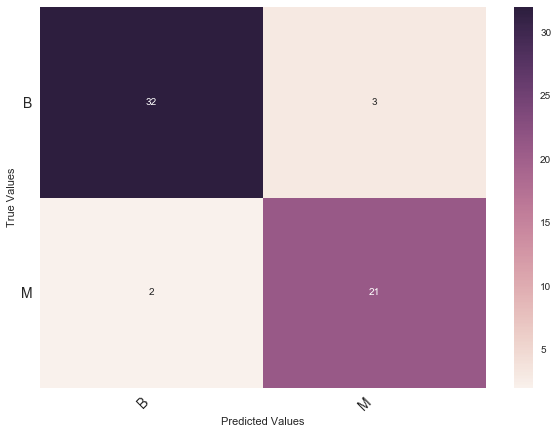

In [206]:
cm = confusion_matrix(y_act,y_pred)
class_name = ['B','M']
print_confusion_matrix(cm,class_name)

In [209]:
#se_varimp=pd.DataFrame(mod_best.varimp())
#se_varimp.head()
##variable	relative_importance	scaled_importance	percentage
#se_varimp.rename(columns={0:"variable",1:"relative_importance",2:"scaled_importance",3:"percentage"}).head()

## Deep Learning

In [210]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[16])

In [211]:
deep = mod_best._id
deep

'DeepLearning_grid_0_AutoML_20181101_171828_model_0'

Confusion Matrix

In [212]:
mod_best.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


In [213]:
mod_best.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.9886645951195379: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,4.0,144.0,0.027,(4.0/148.0)
Total,273.0,144.0,0.0096,(4.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.9999999990311449: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,19.0,129.0,0.1284,(19.0/148.0)
Total,288.0,129.0,0.0456,(19.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max precision @ threshold = 0.9999999990311449: 


,B,M,Error,Rate
B,269.0,0.0,0.0,(0.0/269.0)
M,19.0,129.0,0.1284,(19.0/148.0)
Total,288.0,129.0,0.0456,(19.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Confusion Matrix (Act/Pred) for max min_per_class_accuracy @ threshold = 0.11208374333751887: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,1.0,147.0,0.0068,(1.0/148.0)
Total,268.0,149.0,0.0072,(3.0/417.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


[, , , , , , , , , ]

In [214]:
mod_best._get_metrics
type(mod_best)
mods=mod_best.coef_norm
print(mods)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_0_AutoML_20181101_171828_model_0


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.007912352516752276
RMSE: 0.0889514053669321
LogLoss: 0.023663911885297664
Mean Per-Class Error: 0.0037174721189591198
AUC: 0.9998241736159952
Gini: 0.9996483472319904
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09828394643134256: 


,B,M,Error,Rate
B,267.0,2.0,0.0074,(2.0/269.0)
M,0.0,148.0,0.0,(0.0/148.0)
Total,267.0,150.0,0.0048,(2.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0982839,0.9932886,21.0
max f2,0.0982839,0.9973046,21.0
max f0point5,0.9886646,0.9944751,15.0
max accuracy,0.0982839,0.9952038,21.0
max precision,1.0000000,1.0,0.0
max recall,0.0982839,1.0,21.0
max specificity,1.0000000,1.0,0.0
max absolute_mcc,0.0982839,0.9896115,21.0
max min_per_class_accuracy,0.1120837,0.9925651,20.0
max mean_per_class_accuracy,0.0982839,0.9962825,21.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 35.28 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2326139,1.0,2.8175676,2.8175676,1.0,1.0,1.0,1.0,0.6554054,0.6554054,181.7567568,181.7567568
,2,0.2997602,1.0000000,2.8175676,2.8175676,1.0,1.0000000,1.0,1.0000000,0.1891892,0.8445946,181.7567568,181.7567568
,3,0.4004796,0.0017456,1.5429537,2.4970060,0.5476190,0.5266650,0.8862275,0.8809577,0.1554054,1.0,54.2953668,149.7005988
,4,0.5011990,0.0000003,0.0,1.9952153,0.0,0.0001351,0.7081340,0.7039503,0.0,1.0,-100.0,99.5215311
,5,0.5995204,0.0000000,0.0,1.668,0.0,0.0000000,0.592,0.5885024,0.0,1.0,-100.0,66.8
,6,0.7002398,0.0000000,0.0,1.4280822,0.0,0.0000000,0.5068493,0.5038548,0.0,1.0,-100.0,42.8082192
,7,0.7985612,0.0000000,0.0,1.2522523,0.0,0.0000000,0.4444444,0.4418186,0.0,1.0,-100.0,25.2252252
,8,0.8992806,0.0000000,0.0,1.1120000,0.0,0.0000000,0.3946667,0.3923349,0.0,1.0,-100.0,11.2000000
,9,1.0,0.0000000,0.0,1.0,0.0,0.0000000,0.3549161,0.3528192,0.0,1.0,-100.0,0.0




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.0006555664485382642
RMSE: 0.02560403188051179
LogLoss: 0.004296450984575728
Mean Per-Class Error: 0.0
AUC: 1.0
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8826736770234279: 


,B,M,Error,Rate
B,53.0,0.0,0.0,(0.0/53.0)
M,0.0,41.0,0.0,(0.0/41.0)
Total,53.0,41.0,0.0,(0.0/94.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8826737,1.0,6.0
max f2,0.8826737,1.0,6.0
max f0point5,0.8826737,1.0,6.0
max accuracy,0.8826737,1.0,6.0
max precision,1.0000000,1.0,0.0
max recall,0.8826737,1.0,6.0
max specificity,1.0000000,1.0,0.0
max absolute_mcc,0.8826737,1.0,6.0
max min_per_class_accuracy,0.8826737,1.0,6.0
max mean_per_class_accuracy,0.8826737,1.0,6.0


Gains/Lift Table: Avg response rate: 43.62 %, avg score: 43.76 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2021277,1.0,2.2926829,2.2926829,1.0,1.0,1.0,1.0,0.4634146,0.4634146,129.2682927,129.2682927
,2,0.2021277,1.0000000,0.0,2.2926829,0.0,0.0,1.0,1.0,0.0,0.4634146,-100.0,129.2682927
,3,0.2978723,1.0000000,2.2926829,2.2926829,1.0,1.0000000,1.0,1.0000000,0.2195122,0.6829268,129.2682927,129.2682927
,4,0.4042553,0.9998401,2.2926829,2.2926829,1.0,0.9999891,1.0,0.9999971,0.2439024,0.9268293,129.2682927,129.2682927
,5,0.5,0.0010950,0.7642276,2.0,0.3333333,0.3476743,0.8723404,0.8750843,0.0731707,1.0,-23.5772358,100.0
,6,0.5957447,0.0000003,0.0,1.6785714,0.0,0.0000917,0.7321429,0.7344604,0.0,1.0,-100.0,67.8571429
,7,0.7021277,0.0000000,0.0,1.4242424,0.0,0.0000001,0.6212121,0.6231786,0.0,1.0,-100.0,42.4242424
,8,0.7978723,0.0000000,0.0,1.2533333,0.0,0.0000000,0.5466667,0.5483971,0.0,1.0,-100.0,25.3333333
,9,0.8936170,0.0000000,0.0,1.1190476,0.0,0.0000000,0.4880952,0.4896403,0.0,1.0,-100.0,11.9047619
,10,1.0,0.0000000,0.0,1.0,0.0,0.0000000,0.4361702,0.4375509,0.0,1.0,-100.0,0.0




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.02355217550764335
RMSE: 0.15346718055546388
LogLoss: 0.23519699822060325
Mean Per-Class Error: 0.024326836129810125
AUC: 0.9908821460866071
Gini: 0.9817642921732141
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8636782443690625: 


,B,M,Error,Rate
B,265.0,4.0,0.0149,(4.0/269.0)
M,5.0,143.0,0.0338,(5.0/148.0)
Total,270.0,147.0,0.0216,(9.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8636782,0.9694915,18.0
max f2,0.0197879,0.9692513,27.0
max f0point5,0.9985876,0.9801136,10.0
max accuracy,0.9769969,0.9784173,16.0
max precision,1.0000000,1.0,0.0
max recall,0.0000000,1.0,269.0
max specificity,1.0000000,1.0,0.0
max absolute_mcc,0.8636782,0.9528073,18.0
max min_per_class_accuracy,0.1327100,0.9665428,24.0
max mean_per_class_accuracy,0.8636782,0.9756732,18.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 35.81 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2517986,1.0,2.8175676,2.8175676,1.0,1.0,1.0,1.0,0.7094595,0.7094595,181.7567568,181.7567568
,2,0.2997602,1.0000000,2.8175676,2.8175676,1.0,1.0000000,1.0,1.0000000,0.1351351,0.8445946,181.7567568,181.7567568
,3,0.4004796,0.0005083,1.3416988,2.4463910,0.4761905,0.5792734,0.8682635,0.8941885,0.1351351,0.9797297,34.1698842,144.6391002
,4,0.5011990,0.0000000,0.1341699,1.9817341,0.0476190,0.0000333,0.7033493,0.7145018,0.0135135,0.9932432,-86.5830116,98.1734126
,5,0.5995204,0.0000000,0.0,1.6567297,0.0,0.0000000,0.588,0.5973235,0.0,0.9932432,-100.0,65.6729730
,6,0.7002398,0.0000000,0.0,1.4184330,0.0,0.0000000,0.5034247,0.5114071,0.0,0.9932432,-100.0,41.8432988
,7,0.7985612,0.0000000,0.0,1.2437911,0.0,0.0000000,0.4414414,0.4484411,0.0,0.9932432,-100.0,24.3791088
,8,0.8992806,0.0000000,0.0,1.1044865,0.0,0.0000000,0.392,0.3982157,0.0,0.9932432,-100.0,10.4486486
,9,1.0,0.0000000,0.0670849,1.0,0.0238095,0.0000000,0.3549161,0.3581076,0.0067568,1.0,-93.2915058,0.0



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9856282,0.0063378,0.9761905,0.9880952,0.9879518,0.9759036,1.0
auc,0.9917383,0.0077355,0.9964706,0.9701389,0.9974843,0.9945979,1.0
err,0.0143718,0.0063378,0.0238095,0.0119048,0.0120482,0.0240964,0.0
err_count,1.2,0.5291503,2.0,1.0,1.0,2.0,0.0
f0point5,0.9851413,0.0086454,0.9705882,0.9913793,0.9931507,0.9705882,1.0
f1,0.9805902,0.0076574,0.9705882,0.9787234,0.9830508,0.9705882,1.0
f2,0.9761435,0.0085731,0.9705882,0.9663866,0.9731544,0.9705882,1.0
lift_top_group,2.874148,0.2923685,2.4705882,3.5,2.7666667,2.4411764,3.1923077
logloss,0.2281309,0.1315110,0.1897195,0.574412,0.1465594,0.2132317,0.0167322
max_per_class_error,0.0267647,0.0099779,0.0294118,0.0416667,0.0333333,0.0294118,0.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_lift,validation_classification_error
,2018-11-01 17:23:37,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2018-11-01 17:23:38,2 min 5.420 sec,5366 obs/sec,10.0,1,4170.0,0.1173761,0.0728845,0.9398248,0.9955290,2.8175676,0.0095923,0.1098395,0.0710273,0.9509416,0.9958583,2.2926829,0.0106383
,2018-11-01 17:23:43,2 min 10.689 sec,5545 obs/sec,80.0,8,33360.0,0.0970624,0.0628371,0.9588509,0.9978398,2.8175676,0.0095923,0.0193484,0.0041687,0.9984778,1.0,2.2926829,0.0
,2018-11-01 17:23:49,2 min 15.965 sec,5558 obs/sec,150.0,15,62550.0,0.1035580,0.0498601,0.9531591,0.9987692,2.8175676,0.0119904,0.0302904,0.0058523,0.9962692,1.0,2.2926829,0.0
,2018-11-01 17:23:54,2 min 21.152 sec,5591 obs/sec,220.0,22,91740.0,0.0969616,0.0371383,0.9589363,0.9991962,2.8175676,0.0095923,0.0350589,0.0062419,0.9950020,1.0,2.2926829,0.0
,2018-11-01 17:23:59,2 min 26.817 sec,5675 obs/sec,300.0,30,125100.0,0.1012699,0.0625070,0.9552061,0.9991711,2.8175676,0.0095923,0.0287745,0.0046420,0.9966332,1.0,2.2926829,0.0
,2018-11-01 17:24:04,2 min 31.766 sec,5722 obs/sec,370.0,37,154290.0,0.0889514,0.0236639,0.9654408,0.9998242,2.8175676,0.0047962,0.0256040,0.0042965,0.9973343,1.0,2.2926829,0.0


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
concave points_mean,1.0,1.0,0.0445672
area_se,0.9952375,0.9952375,0.0443550
perimeter_worst,0.9751168,0.9751168,0.0434583
radius_worst,0.8804989,0.8804989,0.0392414
texture_worst,0.8079737,0.8079737,0.0360092
---,---,---,---
concavity_se,0.6504522,0.6504522,0.0289889
compactness_mean,0.6464164,0.6464164,0.0288090
compactness_worst,0.6448309,0.6448309,0.0287383
concave points_worst,0.6445645,0.6445645,0.0287265



See the whole table with table.as_data_frame()
<bound method ModelBase.coef_norm of >


Gain Lift Table

In [215]:
deep_gain_lift = mod_best.gains_lift().as_data_frame()

In [216]:
deep_gain_lift

,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.232614,1.000000e+00,2.817568,2.817568,1.000000,1.000000e+00,1.000000,1.000000,0.655405,0.655405,181.756757,181.756757
1,,2,0.299760,1.000000e+00,2.817568,2.817568,1.000000,1.000000e+00,1.000000,1.000000,0.189189,0.844595,181.756757,181.756757
2,,3,0.400480,1.745649e-03,1.542954,2.497006,0.547619,5.266650e-01,0.886228,0.880958,0.155405,1.000000,54.295367,149.700599
3,,4,0.501199,2.923415e-07,0.000000,1.995215,0.000000,1.351329e-04,0.708134,0.703950,0.000000,1.000000,-100.000000,99.521531
4,,5,0.599520,5.133153e-10,0.000000,1.668000,0.000000,2.266321e-08,0.592000,0.588502,0.000000,1.000000,-100.000000,66.800000
5,,6,0.700240,6.496233e-12,0.000000,1.428082,0.000000,9.987166e-11,0.506849,0.503855,0.000000,1.000000,-100.000000,42.808219
6,,7,0.798561,8.893689e-14,0.000000,1.252252,0.000000,1.539017e-12,0.444444,0.441819,0.000000,1.000000,-100.000000,25.225225
7,,8,0.899281,3.762232e-16,0.000000,1.112000,0.000000,1.437304e-14,0.394667,0.392335,0.000000,1.000000,-100.000000,11.200000
8,,9,1.000000,9.309256e-22,0.000000,1.000000,0.000000,7.174851e-17,0.354916,0.352819,0.000000,1.000000,-100.000000,0.000000


In [217]:
deep_predictions_df=predictions_test(mod_best,test,run_id)
deep_predictions_df.head()

deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,B,M
M,3.1833e-18,1
M,1.62028e-15,1
M,1.45922e-16,1
M,1.01906e-27,1
M,8.40619e-24,1
B,0.978514,0.0214856
M,9.09322e-06,0.999991
M,2.95068e-07,1
B,0.996478,0.00352155
M,1.17582e-17,1


In [218]:
gbm_predictions_df.describe()

Rows:58
Cols:3




,predict,B,M
type,enum,real,real
mins,,0.002075135266529693,0.0010468100665216112
mean,,0.6217691021177613,0.3782308978822388
maxs,,0.9989531899334784,0.9979248647334703
sigma,,0.4633146893404552,0.4633146893404552
zeros,,0,0
missing,0,0,0
0,M,0.025421766189176354,0.9745782338108236
1,M,0.003644810067294002,0.996355189932706
2,M,0.013119387444179398,0.9868806125558206


In [219]:
y_pred= gbm_predictions_df['predict'].as_data_frame()
y_act= test['diagnosis'].as_data_frame()

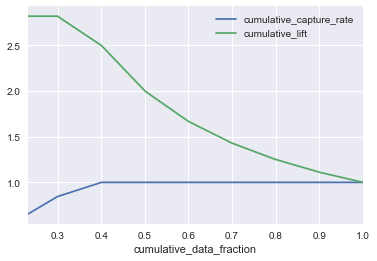

In [221]:
%matplotlib inline 
# plot training logloss and auc
#gbm_predictions_df.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])
deep_gain_lift.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])

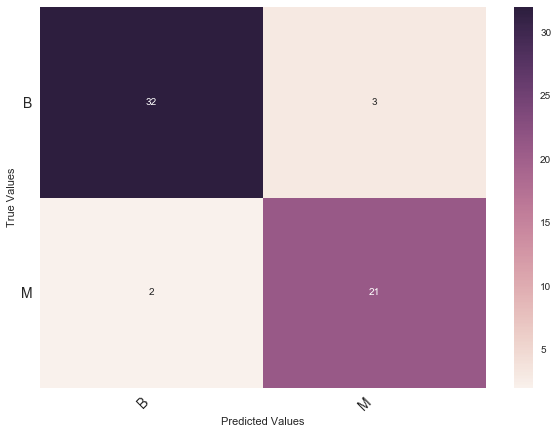

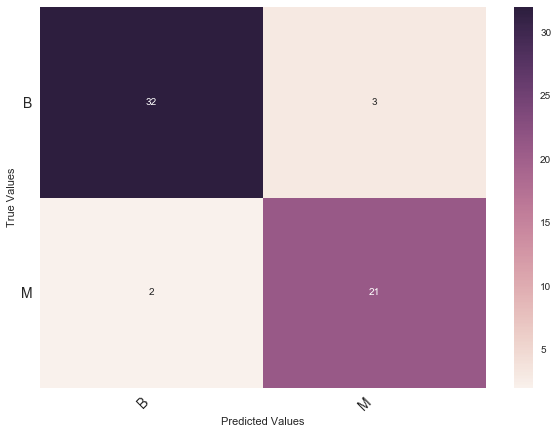

In [222]:
cm = confusion_matrix(y_act,y_pred)
class_name = ['B','M']
print_confusion_matrix(cm,class_name)

Variable Importance

In [224]:
deep_varimp=pd.DataFrame(mod_best.varimp())
deep_varimp.head()

,0,1,2,3
0,concave points_mean,1.000000,1.000000,0.044567
1,area_se,0.995237,0.995237,0.044355
2,perimeter_worst,0.975117,0.975117,0.043458
3,radius_worst,0.880499,0.880499,0.039241
4,texture_worst,0.807974,0.807974,0.036009


In [226]:
#variable	relative_importance	scaled_importance	percentage
deep_varimp.rename(columns={0:"variable",1:"relative_importance",2:"scaled_importance",3:"percentage"}).head()

,variable,relative_importance,scaled_importance,percentage
0,concave points_mean,1.000000,1.000000,0.044567
1,area_se,0.995237,0.995237,0.044355
2,perimeter_worst,0.975117,0.975117,0.043458
3,radius_worst,0.880499,0.880499,0.039241
4,texture_worst,0.807974,0.807974,0.036009


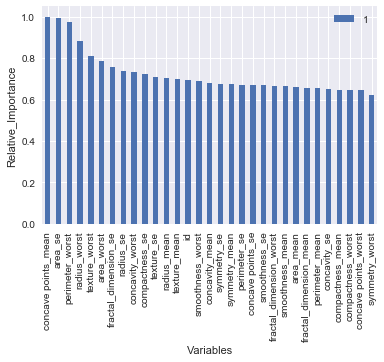

In [227]:
deep_varimp.plot.bar(x=0,y=[1])
plt.xlabel('Variables')
plt.ylabel('Relative_Importance')

## Extremely Randomized Tree

In [228]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[25])

In [229]:
xrt = mod_best._id
xrt

'XRT_0_AutoML_20181101_171828'

Confusion Matrix

In [230]:
mod_best.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,5.0,137.0,0.0352,(5.0/142.0)
Total,256.0,152.0,0.049,(20.0/408.0)


In [231]:
mod_best.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])

Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,5.0,137.0,0.0352,(5.0/142.0)
Total,256.0,152.0,0.049,(20.0/408.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,5.0,137.0,0.0352,(5.0/142.0)
Total,256.0,152.0,0.049,(20.0/408.0)


Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.75: 


,B,M,Error,Rate
B,263.0,3.0,0.0113,(3.0/266.0)
M,22.0,120.0,0.1549,(22.0/142.0)
Total,285.0,123.0,0.0613,(25.0/408.0)


Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.6666666666666669: 


,B,M,Error,Rate
B,260.0,6.0,0.0226,(6.0/266.0)
M,14.0,128.0,0.0986,(14.0/142.0)
Total,274.0,134.0,0.049,(20.0/408.0)


Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.75: 


,B,M,Error,Rate
B,263.0,3.0,0.0113,(3.0/266.0)
M,22.0,120.0,0.1549,(22.0/142.0)
Total,285.0,123.0,0.0613,(25.0/408.0)


Confusion Matrix (Act/Pred) for max recall @ threshold = 0.0: 


,B,M,Error,Rate
B,0.0,266.0,1.0,(266.0/266.0)
M,0.0,142.0,0.0,(0.0/142.0)
Total,0.0,408.0,0.652,(266.0/408.0)


Confusion Matrix (Act/Pred) for max specificity @ threshold = 1.0: 


,B,M,Error,Rate
B,263.0,3.0,0.0113,(3.0/266.0)
M,25.0,117.0,0.1761,(25.0/142.0)
Total,288.0,120.0,0.0686,(28.0/408.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,5.0,137.0,0.0352,(5.0/142.0)
Total,256.0,152.0,0.049,(20.0/408.0)


Confusion Matrix (Act/Pred) for max min_per_class_accuracy @ threshold = 0.5: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,6.0,136.0,0.0423,(6.0/142.0)
Total,257.0,151.0,0.0515,(21.0/408.0)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,5.0,137.0,0.0352,(5.0/142.0)
Total,256.0,152.0,0.049,(20.0/408.0)


[, , , , , , , , , ]

In [232]:
mod_best._get_metrics
type(mod_best)
mods=mod_best.coef_norm
print(mods)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_0_AutoML_20181101_171828


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.03926979124983327
RMSE: 0.19816606987532773
LogLoss: 0.6590704091656039
Mean Per-Class Error: 0.04580112252462132
AUC: 0.9747961452928094
Gini: 0.9495922905856189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4: 


,B,M,Error,Rate
B,251.0,15.0,0.0564,(15.0/266.0)
M,5.0,137.0,0.0352,(5.0/142.0)
Total,256.0,152.0,0.049,(20.0/408.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4,0.9319728,7.0
max f2,0.4,0.9513889,7.0
max f0point5,0.75,0.9463722,3.0
max accuracy,0.6666667,0.9509804,4.0
max precision,0.75,0.9756098,3.0
max recall,0.0,1.0,12.0
max specificity,1.0,0.9887218,0.0
max absolute_mcc,0.4,0.8949922,7.0
max min_per_class_accuracy,0.5,0.9436090,6.0
max mean_per_class_accuracy,0.4,0.9541989,7.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 34.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2877698,1.0,2.7471284,2.7471284,0.975,1.0,0.975,1.0,0.7905405,0.7905405,174.7128378,174.7128378
,2,0.3213429,0.6666667,2.2138031,2.6914078,0.7857143,0.6940476,0.9552239,0.9680348,0.0743243,0.8648649,121.3803089,169.1407826
,3,0.4052758,0.2000000,0.8050193,2.3007356,0.2857143,0.3871429,0.8165680,0.8477318,0.0675676,0.9324324,-19.4980695,130.0735647
,4,1.0,0.0,0.1136116,1.0,0.0403226,0.0005760,0.3549161,0.3439077,0.0675676,1.0,-88.6388405,0.0




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.043866561597058054
RMSE: 0.2094434568017298
LogLoss: 0.1387344024459384
Mean Per-Class Error: 0.0460193281178094
AUC: 0.9903359410952599
Gini: 0.9806718821905198
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4444444444444444: 


,B,M,Error,Rate
B,52.0,1.0,0.0189,(1.0/53.0)
M,3.0,38.0,0.0732,(3.0/41.0)
Total,55.0,39.0,0.0426,(4.0/94.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4444444,0.9500000,5.0
max f2,0.2222222,0.9478673,7.0
max f0point5,0.4444444,0.9644670,5.0
max accuracy,0.4444444,0.9574468,5.0
max precision,1.0,1.0,0.0
max recall,0.1111111,1.0,8.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.4444444,0.9138682,5.0
max min_per_class_accuracy,0.3333333,0.9433962,6.0
max mean_per_class_accuracy,0.4444444,0.9539807,5.0


Gains/Lift Table: Avg response rate: 43.62 %, avg score: 40.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2659574,1.0,2.2926829,2.2926829,1.0,1.0,1.0,1.0,0.6097561,0.6097561,129.2682927,129.2682927
,2,0.3297872,0.8888889,2.2926829,2.2926829,1.0,0.8888889,1.0,0.9784946,0.1463415,0.7560976,129.2682927,129.2682927
,3,0.4148936,0.4444444,2.0060976,2.2338962,0.875,0.5694444,0.9743590,0.8945869,0.1707317,0.9268293,100.6097561,123.3896185
,4,0.5,0.1666667,0.5731707,1.9512195,0.25,0.2638889,0.8510638,0.7872340,0.0487805,0.9756098,-42.6829268,95.1219512
,5,1.0,0.0,0.0487805,1.0,0.0212766,0.0189125,0.4361702,0.4030733,0.0243902,1.0,-95.1219512,0.0




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.027812934837315333
RMSE: 0.1667721044938731
LogLoss: 0.24492272906853052
Mean Per-Class Error: 0.02956395056766803
AUC: 0.9882447503265346
Gini: 0.9764895006530692
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5555555555555556: 


,B,M,Error,Rate
B,264.0,5.0,0.0186,(5.0/269.0)
M,6.0,142.0,0.0405,(6.0/148.0)
Total,270.0,147.0,0.0264,(11.0/417.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5555556,0.9627119,10.0
max f2,0.5,0.9636119,11.0
max f0point5,0.5833333,0.9668508,9.0
max accuracy,0.5555556,0.9736211,10.0
max precision,1.0,1.0,0.0
max recall,0.0,1.0,22.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.5555556,0.9423170,10.0
max min_per_class_accuracy,0.5,0.9662162,11.0
max mean_per_class_accuracy,0.5555556,0.9704360,10.0


Gains/Lift Table: Avg response rate: 35.49 %, avg score: 35.25 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2470024,1.0,2.8175676,2.8175676,1.0,1.0,1.0,1.0,0.6959459,0.6959459,181.7567568,181.7567568
,2,0.3045564,0.8333333,2.7001689,2.7953820,0.9583333,0.8807870,0.9921260,0.9774716,0.1554054,0.8513514,170.0168919,179.5381996
,3,0.4052758,0.2222222,1.2075290,2.4007676,0.4285714,0.4828042,0.8520710,0.8545365,0.1216216,0.9729730,20.7528958,140.0767632
,4,1.0,0.0,0.0454446,1.0,0.0161290,0.0104167,0.3549161,0.3525180,0.0270270,1.0,-95.4555362,0.0



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9784567,0.0062673,0.9642857,0.9761905,0.9879518,0.9759036,0.9879518
auc,0.9872668,0.0061133,0.9926470,0.9743056,0.981761,0.9882953,0.9993252
err,0.0215433,0.0062673,0.0357143,0.0238095,0.0120482,0.0240964,0.0120482
err_count,1.8,0.5291503,3.0,2.0,1.0,2.0,1.0
f0point5,0.9652575,0.0136060,0.9340659,0.9583333,0.9931507,0.9705882,0.9701493
f1,0.9701702,0.0076204,0.9577465,0.9583333,0.9830508,0.9705882,0.9811321
f2,0.9754202,0.0081241,0.982659,0.9583333,0.9731544,0.9705882,0.9923664
lift_top_group,2.874148,0.2923685,2.4705882,3.5,2.7666667,2.4411764,3.1923077
logloss,0.2446987,0.1245262,0.1090156,0.4737836,0.4440402,0.1265383,0.0701159
max_per_class_error,0.0363911,0.0099925,0.06,0.0416667,0.0333333,0.0294118,0.0175439


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-11-01 17:18:31,1.169 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2018-11-01 17:18:31,1.187 sec,1.0,0.2348881,1.9055877,0.9477778,2.4725593,0.0551724,0.3261640,3.6743379,0.8890934,2.0575360,0.1063830
,2018-11-01 17:18:31,1.204 sec,2.0,0.2710524,2.4078848,0.9288295,2.3726885,0.0734694,0.2629619,1.2055361,0.9473079,2.2926829,0.1063830
,2018-11-01 17:18:31,1.221 sec,3.0,0.2281189,1.4855761,0.9581033,2.5300607,0.0551948,0.2201439,0.4831986,0.9774505,2.2926829,0.0531915
,2018-11-01 17:18:31,1.235 sec,4.0,0.2288689,1.3254672,0.9594112,2.5891161,0.0542857,0.2262671,0.1522018,0.9832029,2.2926829,0.0638298
,2018-11-01 17:18:31,1.246 sec,5.0,0.2301919,1.4152341,0.9548104,2.6114041,0.0531915,0.2133821,0.1379536,0.9894156,2.2926829,0.0531915
,2018-11-01 17:18:31,1.260 sec,6.0,0.2285558,1.1940118,0.9552103,2.7001689,0.0634518,0.2153945,0.1425226,0.9891855,2.2926829,0.0531915
,2018-11-01 17:18:31,1.272 sec,7.0,0.2094852,0.8376496,0.9671304,2.7482831,0.0548628,0.2094179,0.1369925,0.9912563,2.2926829,0.0531915
,2018-11-01 17:18:31,1.289 sec,8.0,0.1997827,0.7420033,0.9716042,2.7477105,0.0443350,0.2078896,0.1358712,0.9919466,2.2926829,0.0319149
,2018-11-01 17:18:31,1.312 sec,9.0,0.1981661,0.6590704,0.9747961,2.7471284,0.0490196,0.2094435,0.1387344,0.9903359,2.2926829,0.0425532


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
concave points_mean,208.5536804,1.0,0.2725254
area_worst,89.2118912,0.4277646,0.1165767
perimeter_worst,87.7009735,0.4205199,0.1146023
perimeter_mean,73.3544006,0.3517291,0.0958551
area_mean,65.0681152,0.3119970,0.0850271
---,---,---,---
smoothness_se,0.9722222,0.0046617,0.0012704
symmetry_worst,0.9573960,0.0045906,0.0012511
fractal_dimension_worst,0.6666667,0.0031966,0.0008712
fractal_dimension_mean,0.0,0.0,0.0



See the whole table with table.as_data_frame()
<bound method ModelBase.coef_norm of >


Gain Lift Table

In [233]:
xrt_gain_lift = mod_best.gains_lift().as_data_frame()
xrt

'XRT_0_AutoML_20181101_171828'

In [234]:
xrt_gain_lift

,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.287770,1.000000,2.747128,2.747128,0.975000,1.000000,0.975000,1.000000,0.790541,0.790541,174.712838,174.712838
1,,2,0.321343,0.666667,2.213803,2.691408,0.785714,0.694048,0.955224,0.968035,0.074324,0.864865,121.380309,169.140783
2,,3,0.405276,0.200000,0.805019,2.300736,0.285714,0.387143,0.816568,0.847732,0.067568,0.932432,-19.498069,130.073565
3,,4,1.000000,0.000000,0.113612,1.000000,0.040323,0.000576,0.354916,0.343908,0.067568,1.000000,-88.638840,0.000000


In [235]:
xrt_predictions_df=predictions_test(mod_best,test,run_id)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [236]:
xrt_predictions_df.head()

predict,B,M
M,0.111111,0.888889
M,0,1
M,0,1
M,0,1
M,0,1
B,0.888889,0.111111
B,0.666667,0.333333
M,0.444444,0.555556
B,0.888889,0.111111
M,0,1


In [237]:
xrt_predictions_df.describe()

Rows:58
Cols:3




,predict,B,M
type,enum,real,real
mins,,0.0,0.0
mean,,0.5881226053639846,0.41187739463601525
maxs,,1.0,1.0
sigma,,0.431090120612793,0.43109012061279295
zeros,,16,21
missing,0,0,0
0,M,0.1111111111111111,0.8888888888888888
1,M,0.0,1.0
2,M,0.0,1.0


In [240]:
y_pred= xrt_predictions_df['predict'].as_data_frame()
y_act= test['diagnosis'].as_data_frame()

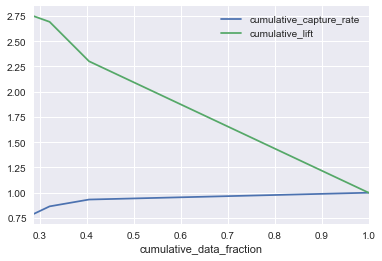

In [241]:
%matplotlib inline 
# plot training logloss and auc
#gbm_predictions_df.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])
xrt_gain_lift.plot(x='cumulative_data_fraction',y = ['cumulative_capture_rate', 'cumulative_lift'])

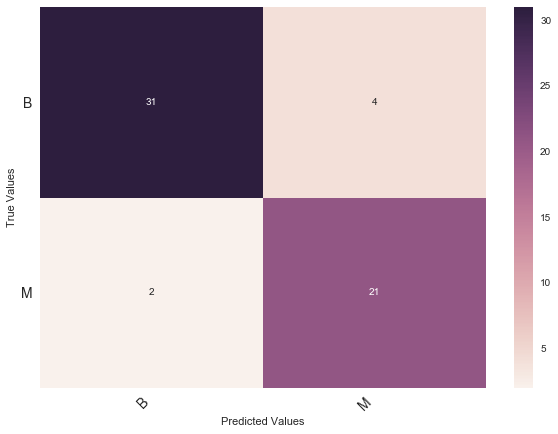

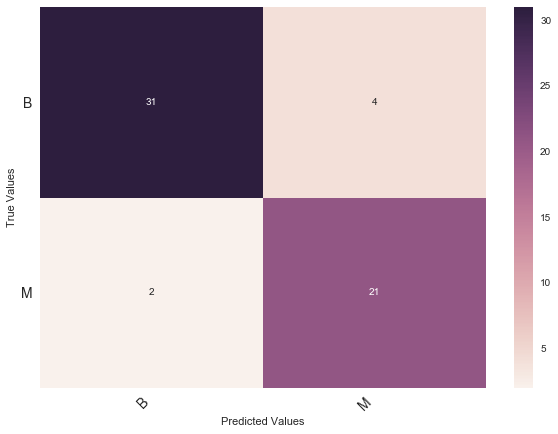

In [242]:
cm = confusion_matrix(y_act,y_pred)
class_name = ['B','M']
print_confusion_matrix(cm,class_name)

Variable Importance

In [244]:
xrt_varimp=pd.DataFrame(mod_best.varimp())
xrt_varimp.head()

,0,1,2,3
0,concave points_mean,208.553680,1.000000,0.272525
1,area_worst,89.211891,0.427765,0.116577
2,perimeter_worst,87.700974,0.420520,0.114602
3,perimeter_mean,73.354401,0.351729,0.095855
4,area_mean,65.068115,0.311997,0.085027


In [247]:
#variable	relative_importance	scaled_importance	percentage
xrt_varimp.rename(columns={0:"variable",1:"relative_importance",2:"scaled_importance",3:"percentage"}).head()

,variable,relative_importance,scaled_importance,percentage
0,concave points_mean,208.553680,1.000000,0.272525
1,area_worst,89.211891,0.427765,0.116577
2,perimeter_worst,87.700974,0.420520,0.114602
3,perimeter_mean,73.354401,0.351729,0.095855
4,area_mean,65.068115,0.311997,0.085027


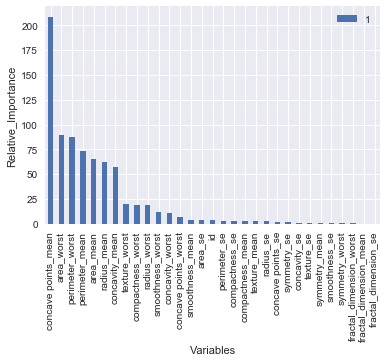

In [248]:
xrt_varimp.plot.bar(x=0,y=[1])
plt.xlabel('Variables')
plt.ylabel('Relative_Importance')